In [29]:
import os.path
import os
#Importando as bibliotecas

import cv2
import numpy as np
import glob
#image configs
import matplotlib.pyplot as plt
import matplotlib

matplotlib.style.use('dark_background')
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
matplotlib.rcParams['image.cmap'] = 'gray'
%matplotlib inline

DATA_PATH = r"D:\Estudos\OpenCV\Computer Vision - Introduction\w8  - Image Recognition\data"

In [13]:
# returns image paths in given folder
# with extensions as defined in imgExts
def getImagePaths(folder, imgExts):
    imagePaths = []
    for x in os.listdir(folder):
        xPath = os.path.join(folder, x)
        if os.path.splitext(xPath)[1] in imgExts:
            imagePaths.append(xPath)
    return imagePaths


# read images in a folder
# return list of images and labels
def getDataset(folder, classLabel):
    images = []
    labels = []
    imagePaths = getImagePaths(folder, ['.jpg', '.png', '.jpeg'])
    for imagePath in imagePaths:
        # print(imagePath)
        im = cv2.imread(imagePath, cv2.IMREAD_COLOR)
        images.append(im)
        labels.append(classLabel)
    return images, labels

## Setup SVM

In [14]:
# Initialize SVM with parameters
def svmInit(C, gamma):
    model = cv2.ml.SVM_create()
    model.setGamma(gamma)
    model.setC(C)
    model.setKernel(cv2.ml.SVM_LINEAR)
    model.setType(cv2.ml.SVM_C_SVC)
    model.setTermCriteria((cv2.TERM_CRITERIA_EPS +
                           cv2.TERM_CRITERIA_MAX_ITER,
                           1000, 1e-3))
    return model


# Train SVM on data and labels
def svmTrain(model, samples, labels):
    model.train(samples, cv2.ml.ROW_SAMPLE, labels)


# predict labels for given samples
def svmPredict(model, samples):
    return model.predict(samples)[1]


# evaluate a model by comparing
# predicted labels and ground truth
def svmEvaluate(model, samples, labels):
    labels = labels[:, np.newaxis]
    pred = model.predict(samples)[1]
    correct = np.sum((labels == pred))
    err = (labels != pred).mean()
    print('label -- 1:{}, -1:{}'.format(np.sum(pred == 1),
                                        np.sum(pred == -1)))
    return correct, err * 100


# create a directory if it doesn't exist
def createDir(folder):
    try:
        os.makedirs(folder)
    except OSError:
        print('{}: already exists'.format(folder))
    except Exception as e:
        print(e)

## Steup HoG

In [15]:
# compute HOG features for given images
def computeHOG(hog, images):
    hogFeatures = []
    for image in images:
        hogFeature = hog.compute(image)
        hogFeatures.append(hogFeature)
    return hogFeatures


# Convert HOG descriptors to format recognized by SVM
def prepareData(hogFeatures):
    featureVectorLength = len(hogFeatures[0])
    data = np.float32(hogFeatures).reshape(-1, featureVectorLength)
    return data

## Initialize HoG

In [16]:
winSize = (64, 128)
blockSize = (16, 16)
blockStride = (8, 8)
cellSize = (8, 8)
nbins = 9

derivAperture = 1
winSigma = -1
histogramNormType = 0
L2HysThreshold = 0.2
gammaCorrection = True
nlevels = 64
signedGradient = False

In [17]:
hog = cv2.HOGDescriptor(winSize, blockSize, blockStride,
                        cellSize, nbins, derivAperture,
                        winSigma, histogramNormType, L2HysThreshold,
                        gammaCorrection, nlevels, signedGradient)

## Setup Training and Testing

In [18]:
trainModel = True
testModel = True
queryModel = True

In [19]:
# Path to INRIA Person dataset
rootDir = DATA_PATH + '\\INRIAPerson\\'

# set Train and Test directory paths
trainDir = os.path.join(rootDir, 'train_64x128_H96')
testDir = os.path.join(rootDir, 'test_64x128_H96')

## Training and SVN


In [40]:
# ================================ Train Model =====================
if trainModel:
    # Read images from Pos and Neg directories
    trainPosDir = os.path.join(trainDir, 'posPatches')
    trainNegDir = os.path.join(trainDir, 'negPatches')

    # Label 1 for positive images and -1 for negative images
    trainPosImages, trainPosLabels = getDataset(trainPosDir, 1)
    trainNegImages, trainNegLabels = getDataset(trainNegDir, -1)

    # Check whether size of all positive and negative images is same
    print(set([x.shape for x in trainPosImages]))
    print(set([x.shape for x in trainNegImages]))

    # Print total number of positive and negative examples
    print('positive - {}, {} || negative - {}, {}'
          .format(len(trainPosImages),len(trainPosLabels),
                  len(trainNegImages),len(trainNegLabels)))

    # Append Positive/Negative Images/Labels for Training
    trainImages = trainPosImages + trainNegImages
    trainLabels = trainPosLabels + trainNegLabels

    # Convert lists to np.arrays
    trainImages = np.array(trainImages)
    trainLabels = np.array(trainLabels)

    # Now compute HOG features for training images and
    # convert HOG descriptors to data format recognized by SVM.
    # Compute HOG features for images
    hogTrain = computeHOG(hog, trainImages)

    # Convert hog features into data format recognized by SVM
    trainData = prepareData(hogTrain)

    # Check dimensions of data and labels
    print('trainData: {}, trainLabels:{}'
          .format(trainData.shape, trainLabels.shape))
    # Finally create an SVM object, train the model and save it.
    # Initialize SVM object
    model = svmInit(C=0.01, gamma=0)
    svmTrain(model, trainData, trainLabels)
    model.save('pedestrian.yml')

{(128, 64, 3)}
{(128, 64, 3)}
positive - 2416, 2416 || negative - 12180, 12180
trainData: (14596, 3780), trainLabels:(14596,)


## Testing SVM

In [41]:
# ================================ Test Model ===============
if testModel:
    # Load model from saved file
    model = cv2.ml.SVM_load('pedestrian.yml')
    # We will evaluate our test dataset for positive and
    # negative images separately to calculate True/False Positives
    # and True/False Negatives
    testPosDir = os.path.join(testDir, 'posPatches')
    testNegDir = os.path.join(testDir, 'negPatches')
    # We will follow the same flow to prepare data as we did for training images.
    # Label 1 for positive images and -1 for negative images
    testPosImages, testPosLabels = getDataset(testPosDir, 1)
    testNegImages, testNegLabels = getDataset(testNegDir, -1)

    # Compute HOG features for images
    hogPosTest = computeHOG(hog, np.array(testPosImages))
    testPosData = prepareData(hogPosTest)

    # Run classification on test data for positive images
    # and calculate True Positives and False Positives.
    posCorrect, posError = svmEvaluate(model, testPosData, np.array(testPosLabels))

    # Calculate True and False Positives
    tp = posCorrect
    fp = len(testPosLabels) - posCorrect
    print('TP: {}, FP: {}, Total: {}, error: {}'
          .format(tp, fp, len(testPosLabels), posError))
    # Similarly run classification on negative test data
    # and calculate True and False Negatives
    # Test on negative images
    hogNegTest = computeHOG(hog, np.array(testNegImages))
    testNegData = prepareData(hogNegTest)
    negCorrect, negError = svmEvaluate(model, testNegData,
                                       np.array(testNegLabels))

    # Calculate True and False Negatives
    tn = negCorrect
    fn = len(testNegData) - negCorrect
    print('TN: {}, FN: {}, Total: {}, error: {}'
          .format(tn, fn, len(testNegLabels), negError))
    # Calculate Precision and Recall
    precision = tp * 100 / (tp + fp)
    recall = tp * 100 / (tp + fn)
    print('Precision: {}, Recall: {}'.format(precision, recall))

label -- 1:1064, -1:62
TP: 1064, FP: 62, Total: 1126, error: 5.506216696269982
label -- 1:18, -1:4512
TN: 4512, FN: 18, Total: 4530, error: 0.3973509933774834
Precision: 94.49378330373001, Recall: 98.33641404805915


## Detect MultiScale

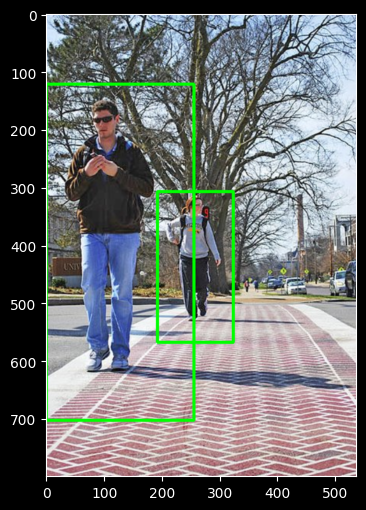

In [42]:
 # ============================== Query Model ===========================================
# Run object detector on a query image to find pedestrians
# We will load the model again and test the model
# This is just to explain how to load an SVM model
# You can use the model directly
if queryModel:
    # load model
    model = cv2.ml.SVM_load(DATA_PATH + '\models\pedestrian.yml')
    # extract support vector and rho(bias) from model
    sv = model.getSupportVectors()
    rho, aplha, svidx = model.getDecisionFunction(0)
    svmDetector = np.zeros(sv.shape[1] + 1, dtype=sv.dtype)
    svmDetector[:-1] = -sv[:]
    svmDetector[-1] = rho

    # set our SVMDetector in HOG
    hog.setSVMDetector(svmDetector)

    filename = DATA_PATH + "/images/pedestrians/3.jpg"
    queryImage = cv2.imread(filename, cv2.IMREAD_COLOR)

    # We will run pedestrian detector at an fixed height image
    finalHeight = 800.0
    scale = finalHeight / queryImage.shape[0]
    queryImage = cv2.resize(queryImage, None, fx=scale, fy=scale)

    # detectMultiScale will detect at nlevels of image by scaling up
    # and scaling down resized image by scale of 1.05
    bboxes, weights = hog.detectMultiScale(queryImage, winStride=(8, 8),
                                           padding=(32, 32), scale=1.05, hitThreshold=1.0)
    # draw detected bounding boxes over image
    for bbox in bboxes:
        x1, y1, w, h = bbox
        x2, y2 = x1 + w, y1 + h
        cv2.rectangle(queryImage, (x1, y1), (x2, y2),
                      (0, 255, 0), thickness=3, lineType=cv2.LINE_AA)
    plt.imshow(queryImage[:,:,::-1])
    plt.show()

## Comparison Models

In [43]:
# Initialize HOG
# Initialize HOG parameters
winSize = (64, 128)
blockSize = (16, 16)
blockStride = (8, 8)
cellSize = (8, 8)
nbins = 9
derivAperture = 1
winSigma = -1
histogramNormType = 0
L2HysThreshold = 0.2
gammaCorrection = True
nlevels = 64
signedGradient = False

# Initialize HOG
hog = cv2.HOGDescriptor(winSize, blockSize, blockStride,
                        cellSize, nbins, derivAperture,
                        winSigma, histogramNormType, L2HysThreshold,
                        gammaCorrection, nlevels, signedGradient)

In [44]:
# Load model trained by us
model = cv2.ml.SVM_load('pedestrian.yml')
sv = model.getSupportVectors()
rho, aplha, svidx = model.getDecisionFunction(0)
svmDetectorTrained = np.zeros(sv.shape[1] + 1, dtype=sv.dtype)
svmDetectorTrained[:-1] = -sv[:]
svmDetectorTrained[-1] = rho
# set SVMDetector trained by us in HOG
hog.setSVMDetector(svmDetectorTrained)

In [45]:
# OpenCV's HOG based Pedestrian Detector
hogDefault = cv2.HOGDescriptor(winSize, blockSize, blockStride,
                               cellSize, nbins, derivAperture,
                               winSigma, histogramNormType,
                               L2HysThreshold,gammaCorrection,
                               nlevels, signedGradient)
svmDetectorDefault = cv2.HOGDescriptor_getDefaultPeopleDetector()
hogDefault.setSVMDetector(svmDetectorDefault)

processing: D:\Estudos\OpenCV\Computer Vision - Introduction\w8  - Image Recognition\data/images/pedestrians\1.jpg
Trained Detector :: pedestrians detected: 4
Default Detector :: pedestrians detected: 6


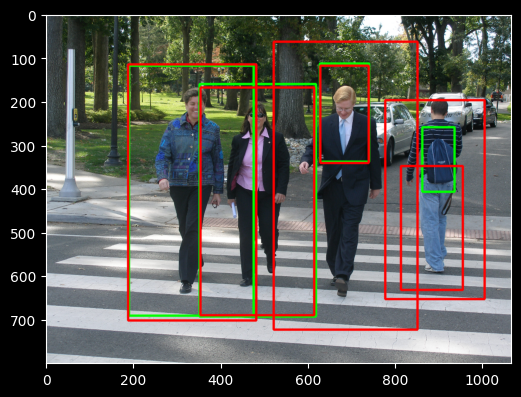

processing: D:\Estudos\OpenCV\Computer Vision - Introduction\w8  - Image Recognition\data/images/pedestrians\2.jpg
Trained Detector :: pedestrians detected: 3
Default Detector :: pedestrians detected: 3


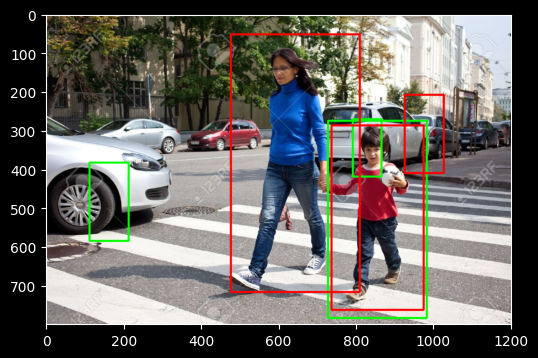

processing: D:\Estudos\OpenCV\Computer Vision - Introduction\w8  - Image Recognition\data/images/pedestrians\3.jpg
Trained Detector :: pedestrians detected: 2
Default Detector :: pedestrians detected: 2


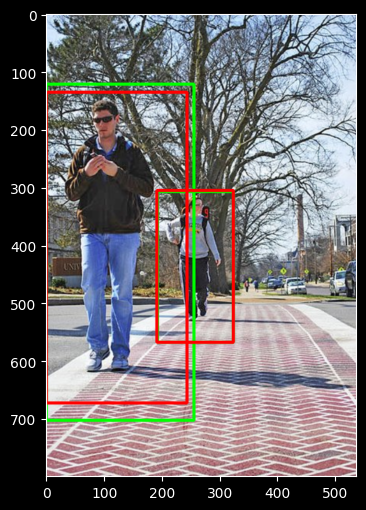

processing: D:\Estudos\OpenCV\Computer Vision - Introduction\w8  - Image Recognition\data/images/pedestrians\4.jpg
Trained Detector :: pedestrians detected: 2
Default Detector :: pedestrians detected: 3


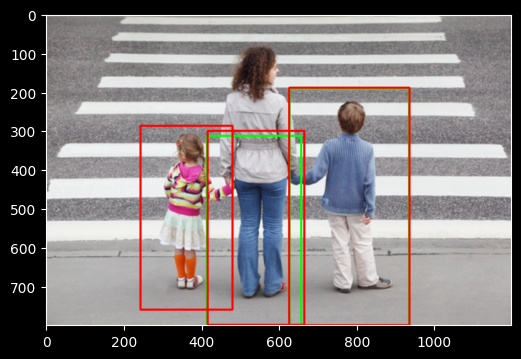

processing: D:\Estudos\OpenCV\Computer Vision - Introduction\w8  - Image Recognition\data/images/pedestrians\5.jpg
Trained Detector :: pedestrians detected: 4
Default Detector :: pedestrians detected: 4


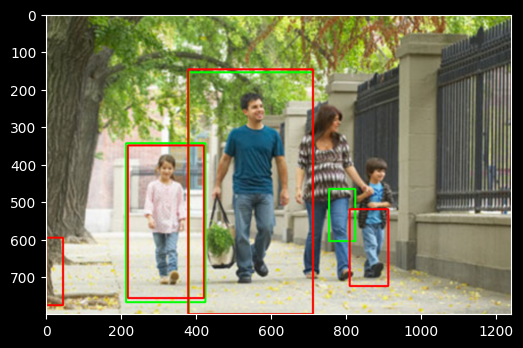

processing: D:\Estudos\OpenCV\Computer Vision - Introduction\w8  - Image Recognition\data/images/pedestrians\race.jpg
Trained Detector :: pedestrians detected: 9
Default Detector :: pedestrians detected: 10


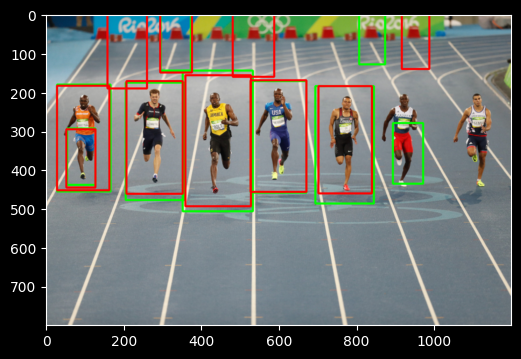

In [46]:
# read images from pedestrians directory
imageDir = DATA_PATH + '/images/pedestrians'
imagePaths = glob.glob(os.path.join(imageDir, '*.jpg'))

# We will run pedestrian detector at an fixed height image
finalHeight = 800.0

for imagePath in imagePaths:
    print('processing: {}'.format(imagePath))

    # read image
    im = cv2.imread(imagePath, cv2.IMREAD_COLOR)

    # resize image to height finalHeight
    scale = finalHeight / im.shape[0]
    im = cv2.resize(im, None, fx=scale, fy=scale)

    # Detect people using trained and default SVM detectors
    # detectMultiScale using detector trained by us
    bboxes, weights = hog.detectMultiScale(im, winStride=(8, 8),
                                           padding=(32, 32),scale=1.05,
                                           hitThreshold=1.0)

    # detectMultiScale using default detector
    bboxes2, weights2 = hogDefault.detectMultiScale(im, winStride=(8, 8),
                                                    padding=(32, 32),scale=1.05,hitThreshold=0)

    # Draw found rectangles on image. We will draw
    # green boxes for people detected by trained model and
    # red boxes for people detected by OpenCV’s default model.
    # print pedestrians detected
    if len(bboxes) > 0:
        print('Trained Detector :: pedestrians detected: {}'
              .format(bboxes.shape[0]))
    if len(bboxes2) > 0:
        print('Default Detector :: pedestrians detected: {}'
              .format(bboxes2.shape[0]))

    # Draw detected bouunding boxes over image
    # Red = default detector, Green = Trained Detector
    for bbox in bboxes:
        x1, y1, w, h = bbox
        x2, y2 = x1 + w, y1 + h
        cv2.rectangle(im, (x1, y1), (x2, y2),
                      (0, 255, 0), thickness=3,
                      lineType=cv2.LINE_AA)

    for bbox in bboxes2:
        x1, y1, w, h = bbox
        x2, y2 = x1 + w, y1 + h
        cv2.rectangle(im, (x1, y1), (x2, y2),
                      (0, 0, 255), thickness=3,
                      lineType=cv2.LINE_AA)
    # Finally show the result and also write it to disk.
    # Show final result
    plt.imshow(im[:,:,::-1])
    # Write image to disk
    imResultPath = os.path.join('results', os.path.basename(imagePath))
    cv2.imwrite(imResultPath, im)
    plt.show()

https://lear.inrialpes.fr/people/triggs/pubs/Dalal-cvpr05.pdf

https://en.wikipedia.org/wiki/Support_vector_machine

http://www.pyimagesearch.com/2015/11/09/pedestrian-detection-opencv/

http://blog.dlib.net/2014/02/dlib-186-released-make-your-own-object.html